# RNN (순환 신경망)
- 이전의 시점의 정보를 현재 시점에 계산에 반영하는 구조

- 첫번째 입력이 들어왔을때 
    - 초기의 상태 (h_0 = 0)와 입력에 대한 상태 (h_1)로 계산
- 두번째 입력이 들어왔을때
    - 이전의 상태 (h_1)과 결합해서 계산 (h_2)
- 반복 작업이 완료가 되었을때
    - 마지막 상태 (h_T) 생성 

- 매개변수 
    - input_size 
        - 각 시점에서 입력의 피쳐의 개수 
    - hidden_size
        - 은닉층(출력)의 크기 
    - num_layers
        - 기본값 : 1
        - RNN 층의 개수 (층이 깊을수록 복잡한 패턴이 생성)
        - 개수가 늘어날수록 시간이 증가하고 과적합의 위험성이 존재
        - 1~3 정도 사용을 할때 1부터 개수를 1씩 늘려가면서 사용
    - nonlinearity
        - 기본값 : 'tanh'
        - 비선형 활성화 함수를 선택 
    - bias
        - 기본값 : True
        - 각 가중치에 편향 항을 추가 여부 
    - batch_first
        - 기본값 : False
        - 입력 텐서 첫 차원이 배치인지 여부 
    - dropout
        - 기본값 : 0.0 
        - 층 사이에 드랍아웃의 적용 비율 -> 층이 2개 이상에 사용
    - bidirectional
        - 기본값 : False
        - 양방향 RNN을 사용할지 여부 (순방향 이 기본 , 역방향을 사용할지 지정)

- 매개변수의 유의점
    - hidden_size
        - 너무 적은 경우라면 정보가 부족, 너무 큰 경우에는 과적합 
        - 일반적으로는 32 ~ 128
    - num_layers
        - 시간의 복잡도에 따라 1 ~ 3정도 사용
        - 1부터 테스트를 돌려서 교차 검증
    - nolinearity
        - 'tanh'이 기본 값이 'relu'로 변경하게 되면 시간은 감소할 수 있지만 불안정 
    - dropout
        - 층이 2개인 경우에 사용
        - 과적합 방지를 위해 0.2 ~ 0.5 사용 (권장)

In [2]:
# RNN 기본형 
# 샘플 데이터를 생성해서 코드 작성 
import math
import numpy as np 
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [3]:
# 랜덤 일관성 설정 
np.random.seed(42)
torch.manual_seed(42)

In [5]:
# 사인 그래프를 생성 + 노이즈 

idx = torch.arange(3000).float()
data = torch.sin(2 * math.pi * 0.02 * idx) + 0.05 * torch.rand(3000)

In [6]:
data

tensor([ 0.0441,  0.1711,  0.2678,  ..., -0.3259, -0.2480, -0.0964])

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(idx, data)
plt.show()

In [13]:
# 연속성이 있는 시계열데이터를 기준으로 train, test를 8:2의 비율로 나눠준다. 
# 앞부분 80% , 뒷부분 20%
# 전체 데이터의 길이에서 0.8을 곱한 idx의 값이 데이터의 경계
split_idx = int(len(data) * 0.8)
train_data = data[ : split_idx]         # 학습 데이터(구간)
test_data = data[split_idx : ]          # 평가 데이터(구간) 


In [15]:
# train와 test를 스케일링 
scaler = StandardScaler()

train_data = scaler.fit_transform(train_data.reshape(-1, 1))
test_data = scaler.transform(test_data.reshape(-1, 1))

In [ ]:
test_data

In [17]:
# data들을 torch에서 사용하기 위한 tensor의 형태로 변환 (2차원의 데이터를 1차원의 데이터로 변환)
train_data = torch.tensor(train_data.squeeze(-1), dtype=torch.float32)
test_data = torch.tensor(test_data.squeeze(-1), dtype=torch.float32)

In [18]:
class WindowDataset(Dataset):
    # 단변량 시계열에서 입력 값 정답 값을 만드는 Dataset
    def __init__(self, _data, _window):
        # _data : (N, ) 형태의 1차원 tensor 데이터
        # _window : 과거의 몇개의 데이터를 볼것인가?(구간 설정)
        self.data = _data
        self.window = _window
        # 유효 샘플의 개수는 학습 데이터의 개수는 data의 전체 길이에서 -1
        # 입력 데이터는 전체 길이 - 윈도우 
        self.n = len(_data) - _window

    # __len__(), __getitem__() 두개의 특수 함수들은 
    # DataLoder에서 자동으로 호출해서 사용이 되는 부분
    def __len__(self):
        return max(self.n, 0)
    
    def __getitem__(self, idx):
        # 변환
        # x -> 입력 데이터 (윈도우의 구간을 나타내는 데이터) --> 문제
        # y -> 입력 데이터 다음 행의 데이터  --> 정답
        x = self.data[idx : idx + self.window].unsqueeze(-1) # (window, ) -> (window, 1)
        y = self.data[idx + self.window].unsqueeze(-1)
        return x, y

In [19]:
# class 생성
# 구간 설정 값 
window = 50
train_ds = WindowDataset(train_data, window)
val_ds = WindowDataset(test_data, window)

In [20]:
# DataLoader : 학습 데이터를 구간 별로 뽑아서 새로운 리스트 형 데이터를 생성
train_dl = DataLoader( train_ds, shuffle=True, drop_last=True, batch_size=64 )
val_dl = DataLoader(val_ds, shuffle=False, drop_last=False, batch_size=256)

### DataLoader
- 파이토치에서 Dataset들을 효율적으로 배치 단위로 꺼내주는 반복자
- 반복 학습 루프에 맞는 형태의 데이터셋을 공급을 해주는 역할
- barch_size(배치 생성) -> Dataset들을 모아서 텐서의 형태로 묶어 줌
- shuffle -> 에폭마다 데이터의 순서를 랜덤하게 변경 
- drop_last -> window에 맞게 구간을 나누고 마지막 구간의 데이터의 개수가 작은 경우 해당 배치를 제거 
- pin_memory -> GPU 사용시 True로 변경하면 CPU -> GPU 전송이 빨라짐

In [22]:
# RNN class 정의 
class RNNReg(nn.Module):
    # 해당 class에서 정의되는 함수는 생성자함수, forward()함수

    def __init__(
            self, 
            input_size, 
            hidden_size, 
            num_layers = 1, 
            nonlinearity = 'tanh', 
            dropout = 0.0, 
            bidirectional = False, 
            batch_first = True
    ):
        # 부모 클래스의 생성자 함수 호출 
        super().__init__()
        self.rnn = nn.RNN(
            input_size = input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            nonlinearity=nonlinearity, 
            dropout=dropout, 
            bidirectional=bidirectional, 
            batch_first=batch_first
        )
        # self.head = nn.Linear(hidden_size, 1) # 1차원 스칼라 회귀
        # bidirectional의 값이 False 인 경우에는 hidden_size를 사용
        # 만약 True라면 hidden_size * 2
        out_features = hidden_size * ( 2 if bidirectional else 1 )
        self.head = nn.Linear(out_features, 1)

    def forward(self, x):
        # out -> 모든 시점에서의 은닉층의 값(결과)
        # h_n -> 마지막 시점에서의 은닉층의 값(결과) -> 층이 존재하면 층별 마지막 값
        #  -> 시계열 분석은 마지막 시점을 사용
        out, h_n = self.rnn(x)
        # 가장 마지막 은닉의 값을 사용(마지막 층의 값)
        last_hidden = h_n[-1]
        res =  self.head(last_hidden)
        return res


In [28]:
rnn_model = RNNReg(
    input_size= 1, hidden_size= 64
)
rnn_model

RNNReg(
  (rnn): RNN(1, 64, batch_first=True)
  (head): Linear(in_features=64, out_features=1, bias=True)
)

In [29]:
# 회귀 분석 -> 손실 함수 -> MSE
criterion = nn.MSELoss()
# 옵티마이저 설정
optimizer = torch.optim.Adam(rnn_model.parameters(), lr = 0.001)
# loss의 미분 폭주 방지용 설정 
max_grad_norm = 1.0

# 검증 단계 함수 생성 
def evaliate_mse(dataloader):
    rnn_model.eval()
    total_loss = 0.0
    total_n = 0
    with torch.no_grad():
        for x, y in dataloader:
            x = x.float()
            y = y.float()
            yhat = rnn_model(x)
            loss = criterion(yhat, y)
            # 총 손실
            total_loss += loss.item() * y.size(0)    
            # loss.item() : 손실의 평균
            # y.size(0) : 개수 
            total_n += y.size(0)
    return total_loss / max(total_n, 1)

In [30]:
# 반복 학습 루프 

# 학습 데이터의 loss들  검증 데이터의 loss 들을 저장 -> 시각화
train_history = []
val_history = []

for epoch in range(20):
    rnn_model.train()
    running = 0.0
    n_seen = 0

    for x, y in train_dl:
        x = x.float()
        y = y.float()

        optimizer.zero_grad()
        yhat = rnn_model(x)
        loss = criterion(yhat, y)
        loss.backward()
        # 미분값 폭주 방지 
        nn.utils.clip_grad_norm_(rnn_model.parameters(), max_grad_norm)

        optimizer.step()

        running += loss.item() * y.size(0)
        n_seen += y.size(0)
    train_mse = running / max(n_seen, 1)
    val_mse = evaliate_mse(val_dl)
    train_history.append(train_mse)
    val_history.append(val_mse)
    print(f"Epoch : {epoch + 1}, train_mse : {round(train_mse, 5)}, \
          val_mse : {round(val_mse, 5)}")

Epoch : 1, train_mse : 0.32359,           val_mse : 0.02058
Epoch : 2, train_mse : 0.00812,           val_mse : 0.00427
Epoch : 3, train_mse : 0.00283,           val_mse : 0.00265
Epoch : 4, train_mse : 0.00219,           val_mse : 0.00235
Epoch : 5, train_mse : 0.00203,           val_mse : 0.00215
Epoch : 6, train_mse : 0.00193,           val_mse : 0.00245
Epoch : 7, train_mse : 0.0022,           val_mse : 0.00218
Epoch : 8, train_mse : 0.00184,           val_mse : 0.00182
Epoch : 9, train_mse : 0.0017,           val_mse : 0.0017
Epoch : 10, train_mse : 0.00154,           val_mse : 0.00169
Epoch : 11, train_mse : 0.00146,           val_mse : 0.00144
Epoch : 12, train_mse : 0.00134,           val_mse : 0.0012
Epoch : 13, train_mse : 0.00122,           val_mse : 0.00126
Epoch : 14, train_mse : 0.00115,           val_mse : 0.00093
Epoch : 15, train_mse : 0.00107,           val_mse : 0.00091
Epoch : 16, train_mse : 0.0009,           val_mse : 0.00092
Epoch : 17, train_mse : 0.00092,      

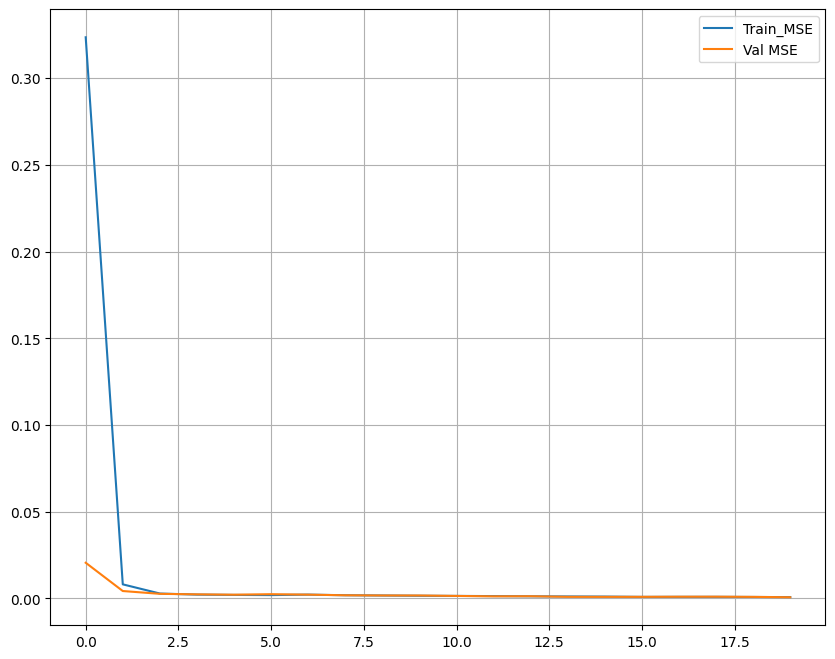

In [31]:
# MSE의 곡선을 그래프로 확인 
plt.figure(figsize=(10, 8))
plt.plot(train_history, label='Train_MSE')
plt.plot(val_history, label='Val MSE')
plt.legend()
plt.grid(True)
plt.show()


In [32]:
# 검증 구간의 데이터와 실제의 예측데이터를 비교 시각화
rnn_model.eval()
preds = []
trues = []

with torch.no_grad():
    for x, y in val_dl:
        x = x.float()
        y = y.float()
        yhat = rnn_model(x)
        preds.append(yhat.cpu())
        trues.append(y.cpu())

In [ ]:
preds = torch.cat(preds, dim = 0).squeeze(-1).numpy()
trues = torch.cat(trues, dim = 0).squeeze(-1).numpy()

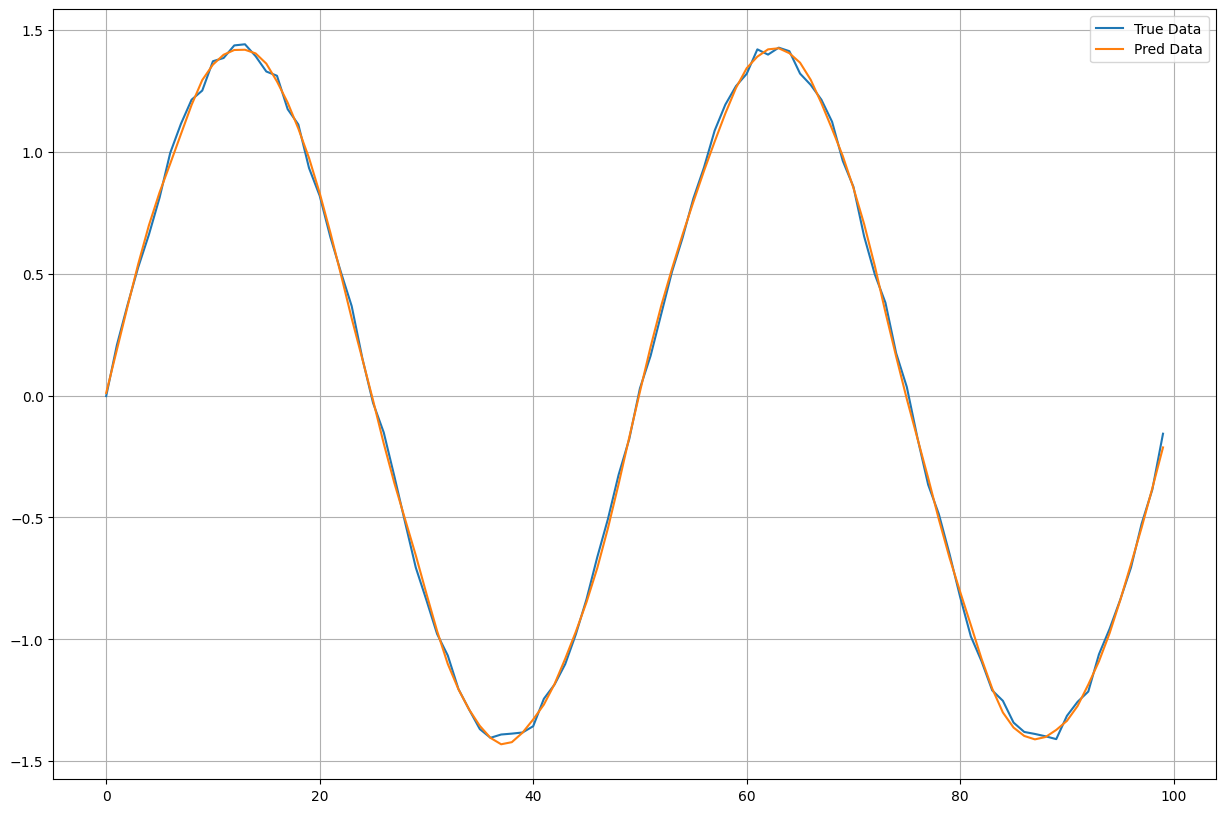

In [43]:
plt.figure(figsize=(15, 10))
plt.plot(trues[:100], label='True Data')
plt.plot(preds[:100], label='Pred Data')
plt.legend()
plt.grid(True)
plt.show()